In [1]:
# Melova lestvica (angl. mel scale) je osnovana na logaritemski skali in posnema 
# občutljivost človeškega ušesa, bolje loči dve nizki kot dve visoki frekvenci.

# It is observed that human ear acts as filter
# More filters in the low frequency regions less no. of filters in high frequency regions

# Pogosto se uporablja tudi v računalniški analizi govora in glasbe.
# Zelo popularni so Melovi frekvenčni kepstralni koeficienti (angl. mel frequency cepstral coefficients - MFCCs), 
# ki sledijo tej lestvici in skušajo oceniti amplitudna razmerja različnih frekvenčnih pasov v posameznem 
# časovnem odseku posnetega signala.

# Postopek je sledeč:
# - Zvočni posnetek najprej z izbrano okensko funkcijo (Hammingovo okno) razdelimo v posamezne odseke. 
#   - Dolžina okna naj bo med 20-40ms; Standard je 25ms.
#   - Za vsak odsek izračunamo DFT in amplitude posameznih Fourierovih frekvenc.
#   --- Z drugo besedo, računamo STDFT.
#   - Korak je običajno 10ms; Predstavlja % prekrivanja.
#   - Število preiskovanih frekvenc je običajno 256 ali 512.

# - Celotno frekvenčno os razdelimo na posamezne frekvenčne pasove.
#   To naredimo s pomočjo banke filtrov (en filter za en frekvenčni pas), 
#   katerih amplituda frekvenčne karakteristike ima trikotno obliko.
#   Spodnjih nekaj frekvenčnih pasov je enake širine in razmaknjeni so po linearni lestvici. 
#   Širine in razmiki vseh nadaljnji h pasov sledijo logaritemski lestvici.
#   Število filtrov naj bo med 20-40; Standard je 26

# - Na vsakem frekvenčnem pasu izračunamo vsoto dobljenih filtriranih amplitud frekvenc.
# - Dobljene vrednosti nelinearno rektificiramo (npr. uporabimo logaritemsko funkcijo).
# - Rektificirane vrednosti vstavimo v diskretno kosinusno transformacijo (angl. discrete cosine transform) 
#   in s tem zmanjšamo korelacijo (redundanco med njimi).
# - Za nadaljnjo uporabo vzamemo nekaj spodnjih koeficientov MFCC, ostale pa zavržemo. 

# Zelo dobra razlaga MFCC:
# - https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
# - http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

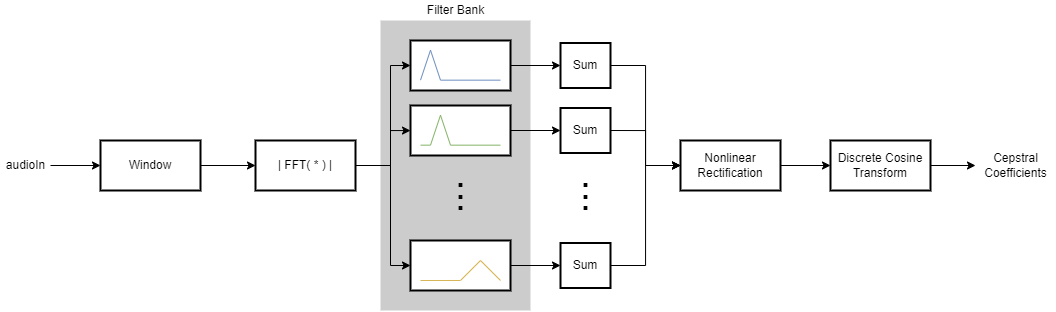

In [2]:
# Povzeto po: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

import numpy as np
import scipy.io.wavfile as wav
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy
import librosa

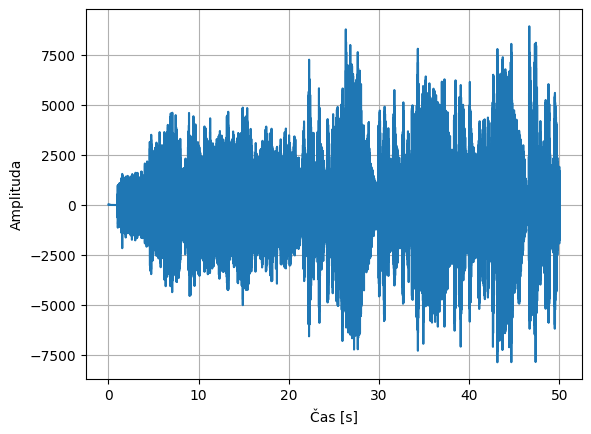

In [3]:
# Naložimo prvih 50 sekund signala
duration = 50
sampling_rate, signal = wav.read('sound.wav')
signal = signal[0:int(duration * sampling_rate)]

t = np.linspace(0, 50, int(sampling_rate * duration), endpoint=False)

plt.plot(t, signal)
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.grid(True)
plt.show()

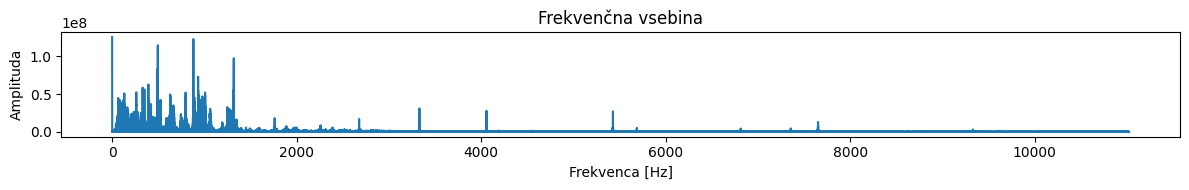

In [4]:
# FFT
N = len(signal)
Y = np.fft.fft(signal)

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, sampling_rate/2, N//2)

# Amplitude
ampl = 2*abs(Y[:N//2])

plt.figure(figsize=(12, 2))
plt.plot(x, ampl)
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.tight_layout()
plt.show()

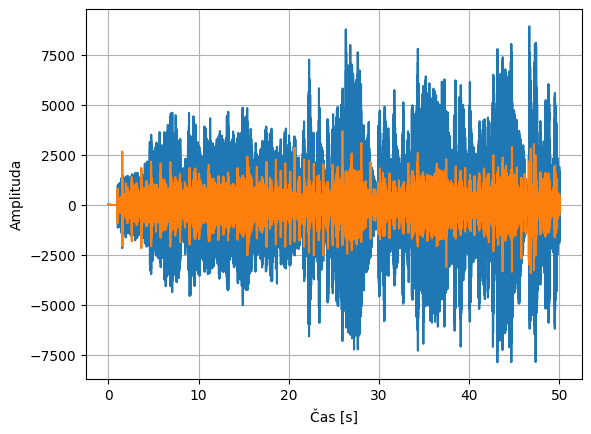

In [5]:
# Uporabimo "filter za predpoudarjanje" - pre-emphasis
# Uravnotežimo frekvenčno vsebino
# Koeficient (α) je 0.95 ali 0.97

pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

plt.plot(t, signal)
plt.plot(t, emphasized_signal)
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.grid(True)
plt.show()

In [6]:
# Delitev signala na okna
# Dejansko delamo STDFT

# 20 do 40 ms z 50% (+/-10%) prekrivanjem; standard je 25 ms
frame_length = int(0.020 * sampling_rate) # 20 ms
frame_step = int(0.010 * sampling_rate) # 10 ms

signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) 

# Razširimo zignal z 0, da so vsa okna polna
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

print(len(emphasized_signal))
print(frame_length)
print(frame_step)
print(np.shape(indices))
print(np.shape(frames))

# Apliciramo Hammingovo okno
frames *= np.hamming(frame_length)

# Fourierova transformacija
# NFFT je 256 ali 512
nfft = 512

# FFT in mangitude
mag_frames = np.abs(np.fft.rfft(frames, nfft))

# Močnostni spekter - PSD
pow_frames = ((1.0 / nfft) * ((mag_frames) ** 2))


1102500
441
220
(5010, 441)
(5010, 441)


In [7]:
# Izračun banke filtrov
# Več: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

# Število filtrov je ponavadi med 20-40; standard je 26
nfilt = 26

# Nastavitev spodnje in zgornje frekvence filtrov
low_freq = 300   # Hz
high_freq = 8000 # Hz

# Pretvorba Hz v Mel-ovo skalo
low_freq_mel = (2595 * np.log10(1 + (low_freq / 700)))
high_freq_mel = (2595 * np.log10(1 + (high_freq / 700)))

print(f"low_freq {low_freq}; low_mel: {low_freq_mel}")
print(f"high_freq {high_freq}; high_mel: {high_freq_mel}")

# Izračun linearno porazdelejenih točk na melovi skali
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
print(f'Mel-ove točke: {mel_points}')

# Pretvorba Mel-ovih točk nazaj v frekvence
hz_points = (700 * (10**(mel_points / 2595) - 1))
print(f'Frekvenčne točke: {hz_points}')

# Frekvenčni razdelki
# Ker nimamo zadostne frekvenčne resolucije, da bi filtre nastavili na izračunane frekvenčne točke. Zaokrožimo na najbljižji frekvenčni razdelek
bin = np.floor((nfft + 1) * hz_points / sampling_rate)
print(f'Frekvenčni razdelki: {bin}')

low_freq 300; low_mel: 401.9705861630035
high_freq 8000; high_mel: 2840.023046708319
Mel-ove točke: [ 401.97058616  492.26882544  582.56706472  672.865304    763.16354328
  853.46178256  943.76002184 1034.05826112 1124.3565004  1214.65473968
 1304.95297896 1395.25121824 1485.54945752 1575.8476968  1666.14593608
 1756.44417535 1846.74241463 1937.04065391 2027.33889319 2117.63713247
 2207.93537175 2298.23361103 2388.53185031 2478.83008959 2569.12832887
 2659.42656815 2749.72480743 2840.02304671]
Frekvenčne točke: [ 300.          383.42040146  473.7997663   571.71861405  677.80589138
  792.74301197  917.26823331 1052.18139861 1198.34907431 1356.71011621
 1528.28169979 1714.16585376 1915.55653848 2133.74731496 2370.13965362
 2626.25193607 2903.72920794 3204.35374523 3530.0565021  3882.92951372
 4265.23933362 4679.44159219 5128.19676945 5614.38728376 6141.13600596
 6711.82631804 7330.12384505 8000.        ]
Frekvenčni razdelki: [  6.   8.  11.  13.  15.  18.  21.  24.  27.  31.  35.  39.  4

Oblika banke filtrov: (26, 257)


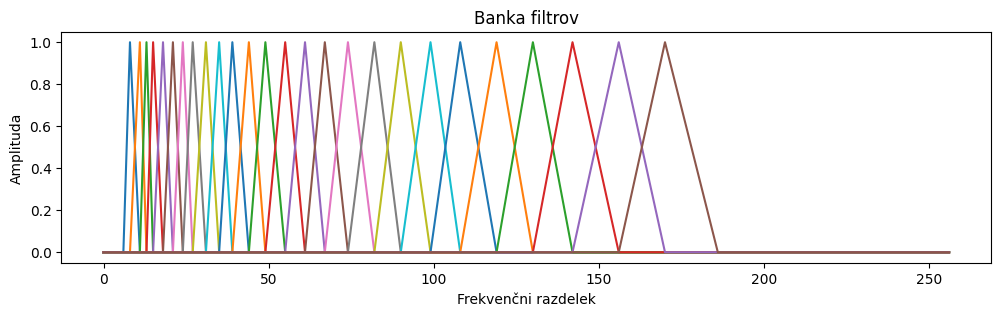

In [8]:
# Nastavimo banko filtrov
fbank = np.zeros((nfilt, int(np.floor(nfft / 2 + 1))))

for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # Leva točka
    f_m = int(bin[m])             # Sredinska točka trikotnika
    f_m_plus = int(bin[m + 1])    # Desna točka

    # Točke v levem delu
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])

    # Točke v desnem delu
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

print(f'Oblika banke filtrov: {np.shape(fbank)}')

plt.figure(figsize=(12,3))
for i in range (0, nfilt):
    plt.plot(fbank[i])

plt.title('Banka filtrov')
plt.xlabel('Frekvenčni razdelek')
plt.ylabel('Amplituda')
plt.show()

(5010, 26)


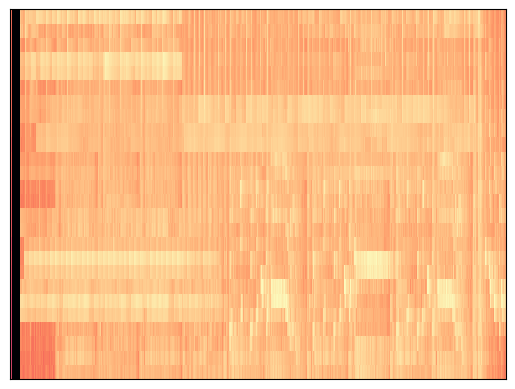

In [9]:
# Apliciranje banke filtrov
filter_banks = np.dot(pow_frames, fbank.T)
print(np.shape(filter_banks))
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability

# Pretvorba v dB
filter_banks = 20 * np.log10(filter_banks)

# Izris
img = librosa.display.specshow(filter_banks.T, sr=sampling_rate, fmin=low_freq, fmax=high_freq)

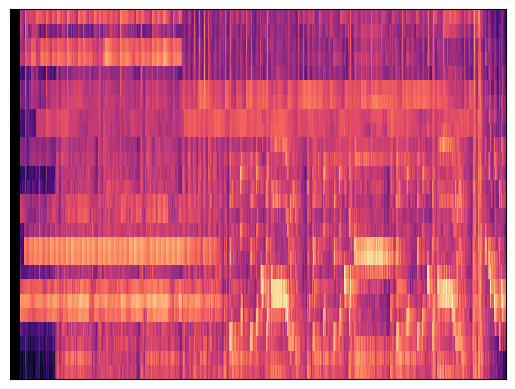

In [10]:
# Uporaba funkcije melspectrogram iz librosa knjižnice
mel_spec = librosa.feature.melspectrogram(y=emphasized_signal, sr=sampling_rate, n_fft=512, hop_length=frame_step, win_length=frame_length, window='hann', n_mels=26, fmin=300, fmax=8000)

img = librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), fmin=300, fmax=8000)

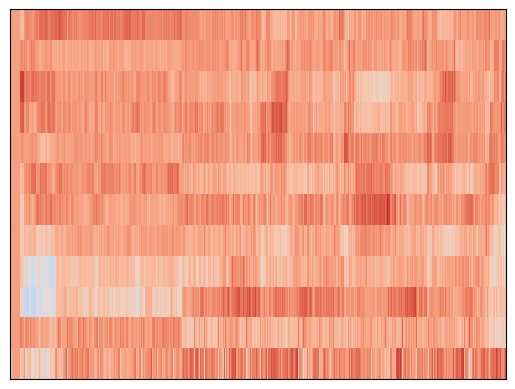

In [11]:
# Mel-frekvenčni kepstralni koeficienti (MFCC)

# Izkaže se, da so koeficienti izračunani z banko filtrov visoko korelirani, kar je neučinkovito za uporabo v algoritmih strojnega učenja
# Dobljene rezultate (filtrirane amplitud frekvenc -> nelinearno rektificirane) vstavimo v diskretno kosinusno transformacijo (DCT)
# in tako opravimo dekorelacijo retultatov prejšnjega koraka
# Rezultat DCT bo stisnjena predstavitev rezultatov prejšnjega koraka z banko filtrov

# Po izračunu DCT ohranimo samo N spodnjih koeficientov, ostale zavrnemo
# Za prepoznavo govora običajno uporabimo med 3-12 koeficientov

n_mfcc = 12
mfcc = scipy.fft.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(n_mfcc+1)]

# Izris z uporabo specshow
img = librosa.display.specshow(mfcc.T, sr=sampling_rate, fmin=low_freq, fmax=high_freq)

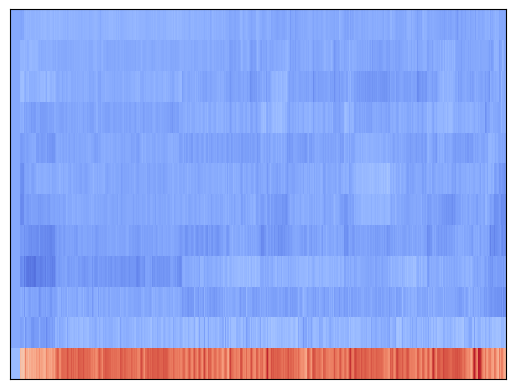

In [12]:
# Uporaba funkcije mfcc iz librosa knjižnice
mfcc = librosa.feature.mfcc(y=emphasized_signal, sr=sampling_rate, n_mfcc=n_mfcc, dct_type=2, norm='ortho', n_fft=nfft, hop_length=frame_step, win_length=frame_length, window=scipy.signal.windows.hann, n_mels=26, fmin=300, fmax=8000)

img = librosa.display.specshow(mfcc, sr=sampling_rate, fmin=low_freq, fmax=high_freq)

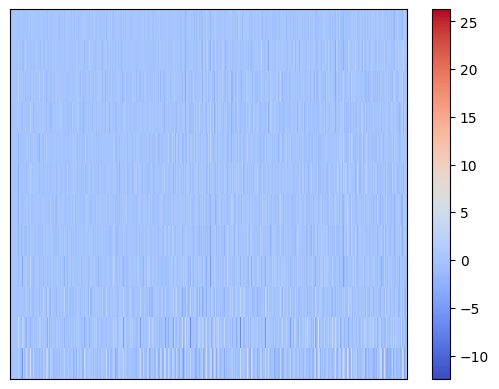

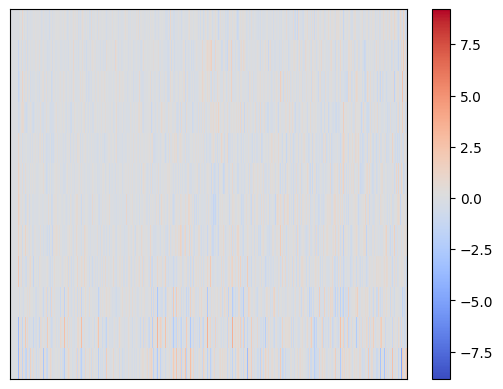

In [13]:
# Delta in Delta-Delta

# Ker merijo koeficienti MFCC le porazdelitev energije v frekvenčni smeri (na izbranem odseku signala),
# zvočni signali pa so nestacionarni (njihova energija niha s časom), 
# nas pogosto zanimajo tudi časovne razlike med vrednostmi posameznega koeficienta.
# Zato pogosto izračunamo povprečno razliko med dvema ali več zaporednim vrednostim koeficientov 
# (v žargonu značilnico delta). Pogosto dodamo tudi razliko zaporednih razlik (delta-delta). 

# Glede na to, da je govor v lingvističnem smislu opisan kot zaporedje
# fonemov, akustični signal bolj natančno opišemo kot zaporedje prehodov med fonemi.

delta = librosa.feature.delta(mfcc)
delta_delta = librosa.feature.delta(mfcc, order=2)

plt.figure()
img = librosa.display.specshow(delta)
plt.colorbar()
plt.show()

plt.figure()
img = librosa.display.specshow(delta_delta)
plt.colorbar()
plt.show()